In [60]:
import pandas as pd 
import matplotlib as mpl
import numpy as np

# reading and storing data
data = pd.read_csv('credit_card_fraud.csv', parse_dates=['trans_date_trans_time',])




Data comes from 1st Jan 2019 - 31st Dec 2020. It covers credit cards of 1000 customers doing transactions with a pool of 800 merchants. From the Western United States

In [66]:
# changing data types
data['dob'] = pd.to_datetime(data['dob'])

# creating columns out of our original Dataset --------------------------

data['hour_of_transaction'] = data.trans_date_trans_time.dt.hour # hour of transaction
data['month_of_transaction'] = data.trans_date_trans_time.dt.month # month of transaction
data['dow_of_transaction'] = data.trans_date_trans_time.dt.day_name() # day of week of transaction
data['cust_age'] = (data['trans_date_trans_time'] - data['dob']).astype('timedelta64[Y]') # age of person during transaction

# encoding: 0 = normal time, 1 = odd time
data['Normal_transaction_time'] = 0
data.loc[data.hour_of_transaction < 5,'Normal_transaction_time'] = 1
data.loc[data.hour_of_transaction > 21,'Normal_transaction_time'] = 1

From here we are showing some interesting data that we extracted from our dataset.
The data shown below can help us understand more about our data as well as help us pinpoint some factors that may be better than others in detecting fraud.

1. The number of Fraud purchases in each state
2. The percent of Fraud in each state
3. The number of Fraud purchases in each category of purchase
4. The percent of Fraud purchases in each category of purchase
5. The hours of day where Fraud occurs


Text(0.5, 0, 'States')

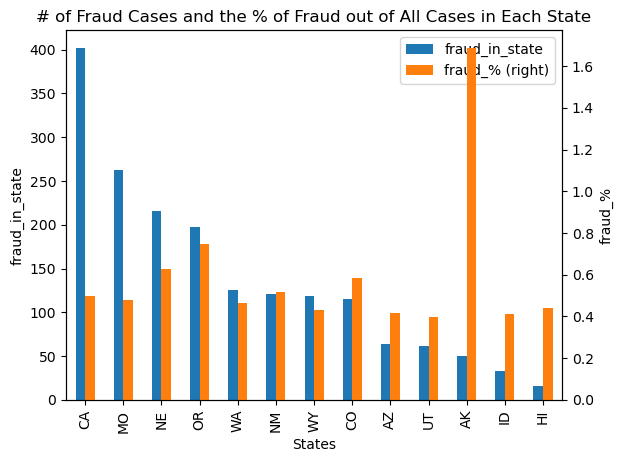

In [58]:
fraud_state_df = pd.DataFrame({'fraud_in_state': data.query('is_fraud==1')['state'].value_counts(),
                               'fraud_%' : data.query('is_fraud==1')['state'].value_counts()/data['state'].value_counts()*100})
fraud_state_df = fraud_state_df.sort_values('fraud_in_state', ascending=False)
ax = fraud_state_df.plot.bar(secondary_y = ['fraud_%'])
ax.set_ylabel('fraud_in_state')
ax.right_ax.set_ylabel('fraud_%')
ax.set_title('# of Fraud Cases and the % of Fraud out of All Cases in Each State')
ax.set_xlabel('States')

Text(0.5, 0, 'Categories')

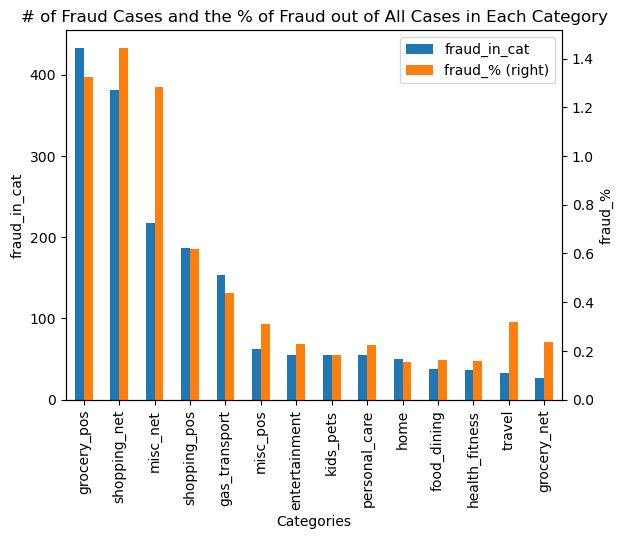

In [49]:
fraud_cat_df = pd.DataFrame({'fraud_in_cat': data.query('is_fraud==1')['category'].value_counts(),
                               'fraud_%' : data.query('is_fraud==1')['category'].value_counts()/data['category'].value_counts()*100})
fraud_cat_df = fraud_cat_df.sort_values('fraud_in_cat', ascending=False)
ax = fraud_cat_df.plot.bar(secondary_y = ['fraud_%'])
ax.set_ylabel('fraud_in_cat')
ax.right_ax.set_ylabel('fraud_%')
ax.set_title('# of Fraud Cases and the % of Fraud out of All Cases in Each Category')
ax.set_xlabel('Categories')


Text(0.5, 0, 'Hours of Day')

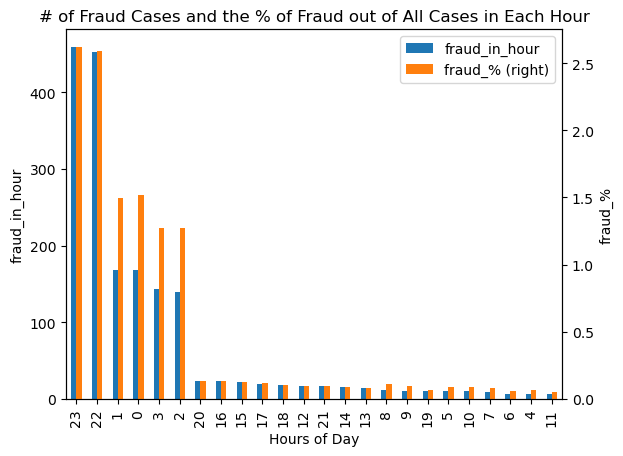

In [59]:
fraud_hour_df = pd.DataFrame({'fraud_in_hour': data.query('is_fraud==1')['hour_of_transaction'].value_counts(),
                               'fraud_%' : data.query('is_fraud==1')['hour_of_transaction'].value_counts()/data['hour_of_transaction'].value_counts()*100})
fraud_hour_df = fraud_hour_df.sort_values('fraud_in_hour', ascending=False)
ax = fraud_hour_df.plot.bar(secondary_y = ['fraud_%'])
ax.set_ylabel('fraud_in_hour')
ax.right_ax.set_ylabel('fraud_%')
ax.set_title('# of Fraud Cases and the % of Fraud out of All Cases in Each Hour')
ax.set_xlabel('Hours of Day')

Text(0.5, 0, 'Age')

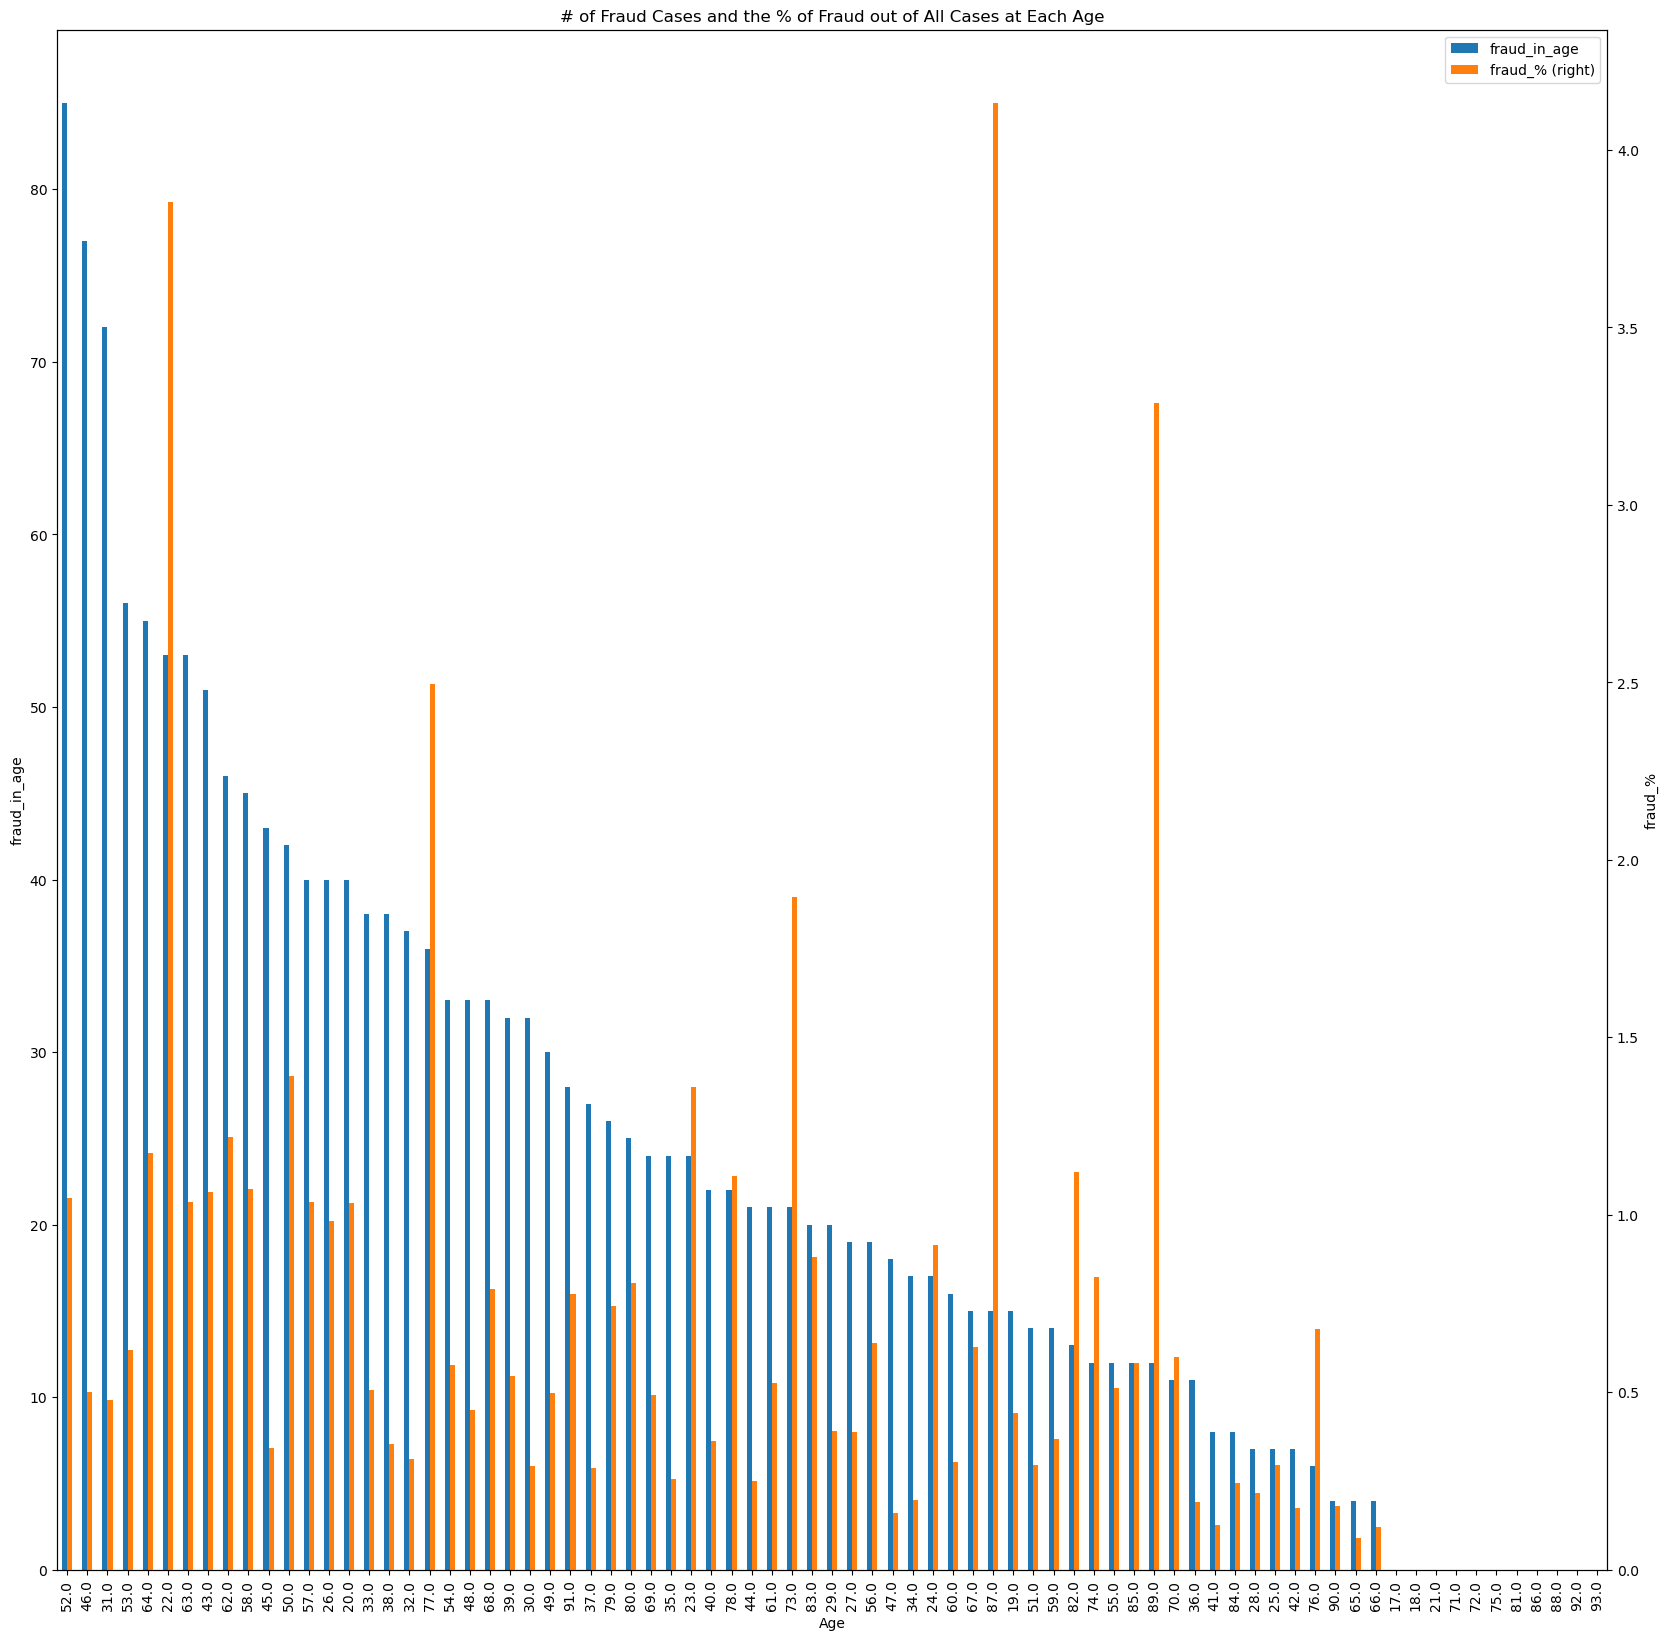

In [71]:
fraud_age_df = pd.DataFrame({'fraud_in_age': data.query('is_fraud==1')['cust_age'].value_counts(),
                               'fraud_%' : data.query('is_fraud==1')['cust_age'].value_counts()/data['cust_age'].value_counts()*100})
fraud_age_df = fraud_age_df.sort_values('fraud_in_age', ascending=False)
ax = fraud_age_df.plot.bar(secondary_y = ['fraud_%'], figsize=(20,20))
ax.set_ylabel('fraud_in_age')
ax.right_ax.set_ylabel('fraud_%')
ax.set_title('# of Fraud Cases and the % of Fraud out of All Cases at Each Age')
ax.set_xlabel('Age')

Text(0.5, 0, 'Day')

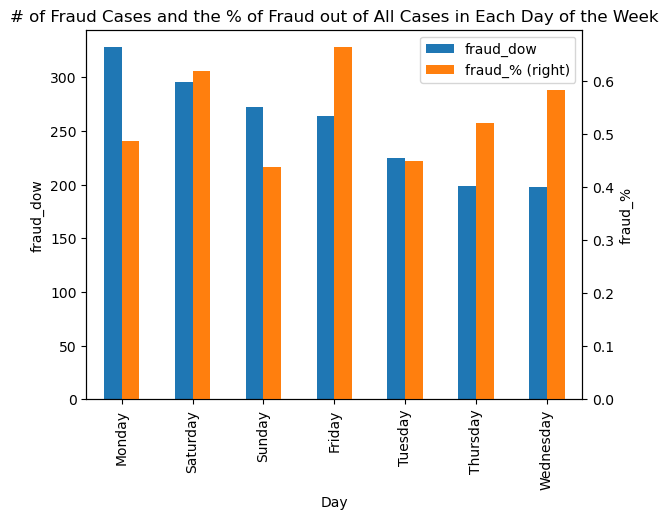

In [72]:
fraud_dow_df = pd.DataFrame({'fraud_dow': data.query('is_fraud==1')['dow_of_transaction'].value_counts(),
                               'fraud_%' : data.query('is_fraud==1')['dow_of_transaction'].value_counts()/data['dow_of_transaction'].value_counts()*100})
fraud_dow_df = fraud_dow_df.sort_values('fraud_dow', ascending=False)
ax = fraud_dow_df.plot.bar(secondary_y = ['fraud_%'])
ax.set_ylabel('fraud_dow')
ax.right_ax.set_ylabel('fraud_%')
ax.set_title('# of Fraud Cases and the % of Fraud out of All Cases in Each Day of the Week')
ax.set_xlabel('Day')

Text(0.5, 0, 'Month')

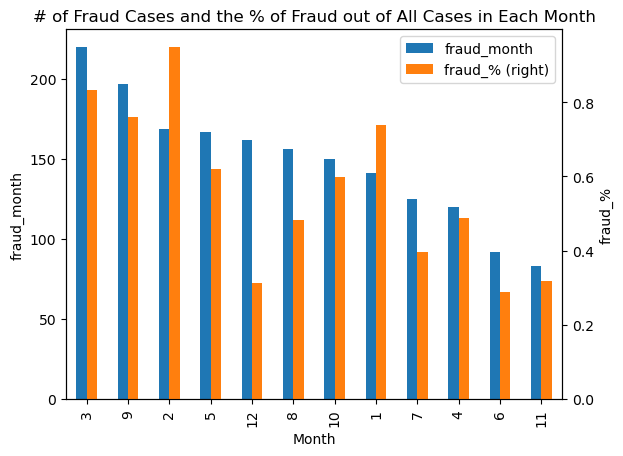

In [73]:
fraud_month_df = pd.DataFrame({'fraud_month': data.query('is_fraud==1')['month_of_transaction'].value_counts(),
                               'fraud_%' : data.query('is_fraud==1')['month_of_transaction'].value_counts()/data['month_of_transaction'].value_counts()*100})
fraud_month_df = fraud_month_df.sort_values('fraud_month', ascending=False)
ax = fraud_month_df.plot.bar(secondary_y = ['fraud_%'])
ax.set_ylabel('fraud_month')
ax.right_ax.set_ylabel('fraud_%')
ax.set_title('# of Fraud Cases and the % of Fraud out of All Cases in Each Month')
ax.set_xlabel('Month')